<center> <h1>SFML-Project-Classification-INFO-F422</h1> </center>

<center> <h2>Bernard Manderick</h2> </center>
 
<center> <h3>Guillaume Buisson-Chavot</h3> </center> 
<center> <h3>matricule: 000465822 </h3> </center> 

## 1. Synthetic dataset:

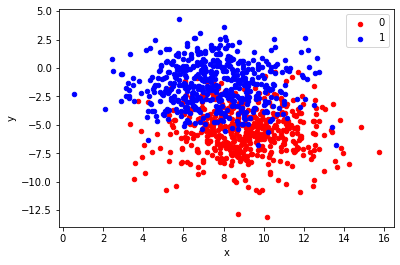

In [275]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
X, y =  make_blobs(n_samples=1000, centers=2, n_features=2, cluster_std= (2,2), center_box = (-10,10))
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()


We can now print a small part of the values of the dataframe we create:

In [276]:
print(df.head())

           x         y  label
0  10.207311 -5.180247      0
1   7.872766 -3.913635      1
2   9.835486 -5.800608      0
3   7.312659 -2.842581      1
4  11.954994 -4.710721      0


### 1.1 Support vector machine with packages

We can use the Support vector machine method:

In [277]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
import pandas as pd


X = np.array(df.drop(['label'], 1))
y = np.array(df['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf_svm = SVC(kernel='linear')

clf_svm.fit(X_train, y_train)
confidence_svm = clf_svm.score(X_test, y_test)
print('confidence =', confidence_svm)


confidence = 0.8466666666666667


### 1.2 Support vector machine from scratch:

I also developed this algorithm from scratch with explainations. Here it is:

In [278]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import shuffle

SVM is a supervised machine learning algorithm used in general for binary classification problems. Given a set of training examples, each marked as belonging to one or the other of two categories, a SVM training algorithm builds a model that assigns new examples to one category or the other, making it a non-probabilistic binary linear classifier. An SVM model is a representation of the examples as points in space, mapped such that the examples of the separate categories are divided by a clear gap that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on the side of the gap on which they fall.


Below is the code of the cost function:
$$J(w) = \frac{1}{2}||w||^2 + C\left[\frac{1}{N}\sum\limits_{i}^{n}max(0, 1-y_i * (w \cdotp x_i + b))\right]$$
The first part of the function corresponds to the margin, in fact the width between the two (positive and negative) hyperplanes is equal to: 
$$width = (x_+ - x_-)* \frac{w}{||w||}$$ and joining the previous equation with the following equations of the two hyperplanes:
$$y_i*(w x_+ + b) -1 = 0$$ and $$ y_i*(w x_- + b) -1 = 0$$ with $$y_i = \begin{cases}
  1 & \text{for } x_+  \\   
  -1 & \text{for } x_-
\end{cases}$$
we obtain $$width = \frac{2}{||w||}$$ and we have to maximize the width which is the same to minimize w and the trick is to transform  $$\text{min }w$$ into $$ min\frac{1}{2}||w||^2$$ 
The second part of the function which begins by C is called Hinge loss function and we have to minimize the sum which corresponds to distance between positive (or negative) hyperplane and our training set. C is a regularization parameter, larger C results in narrow margin and a smaller in a wider margin. N is just the number of lines we have in ours features.

In [279]:
def compute_cost_function(W, X, Y):
    distances = 1 - Y * (np.dot(X, W))
    distances[distances < 0] = 0    # the max between 0 and the distance is kept
    hinge_loss = C * (np.sum(distances) / X.shape[0])
    return 1 / 2 * np.dot(W, W) + hinge_loss ## = cost

Below is the code of the gradient of the cost function:

We can simplify $$max(0, 1-y_i * (w \cdotp x_i + b))$$ into $$max(0, 1-y_i * (W \cdotp X_i))$$ with $$W =(w,b)$$ and $$X = (x_i,1)$$
and we obtain with the previous simplification:

$$J(w) = \frac{1}{2}||w||^2 + C\left[\frac{1}{N}\sum\limits_{i}^{n}max(0, 1-y_i * (W \cdotp X_i))\right]$$
and finally, we have the following gradient of the cost function:

$$\nabla_w J(w) = \frac{1}{N}\sum\limits_{i}^{n}
\begin{cases}
  w & \text{if } max(0, 1-y_i * (W \cdotp X_i))=0 \\   
  w-Cy_ix_i    & \text{otherwise}
\end{cases}$$

In [280]:
def compute_cost_function_gradient(W, X, Y):
    Y = np.array([Y])
    X = np.array([X]) 
    distances = 1 - (Y * np.dot(X, W))
    grad = np.zeros(len(W))
    for index, value in enumerate(distances):
        if max(0, value) == 0:
            dist = W
        else:
            dist = W - (C * Y[index] * X[index])
        grad += dist
    return grad/len(Y)

Now, we have to compute the stochastic gradient descent function: For this purpose, we have to minimise the two parts of the following equation:
𝐽(𝑤)=12||𝑤||2+𝐶[1𝑁∑𝑖𝑛𝑚𝑎𝑥(0,1−𝑦𝑖∗(𝑊⋅𝑋𝑖))]
The gradient is the direction of the inscrease of the function J(w). We need to go to the direction of the decrease, that's why we calculate the gradient of the cost function from the train set. Particularly, we perform the gradient descent by substracting a learning rate multiplied by the gradient of the cost function from the weight initialized with zero value. And we compute the cost for all the 2^n. In this way, we can determine the weight by repeating the procedure a number of times we decide (here 2048 cycles). We can add a criterion to stop before the max_cycles value by comparing the difference between the previous cost and the new cost and if this mesurement is smaller than a percentage of the old cost, we stop the cycles and return directly the weigts.

In [281]:
def compute_stochastic_gradient_descent(features, outputs):
    max_cycles, rate = 2049, 0.001 
    weights = np.zeros(features.shape[1])
    parameter, cycle = 0, 0
    previous_cost = float("inf")
    while cycle <max_cycles:
        cycle += 1
        X, Y = shuffle(features, outputs)
        for index, value_of_X in enumerate(X):
            ascention = compute_cost_function_gradient(weights, value_of_X , Y[index])
            weights = weights - (learning_rate * ascention)
        if cycle == 2**parameter:
            cost = compute_cost_function(weights, features, outputs)
            print("nb_of_cycles: {} and Cost: {}".format(cycle, cost))
            parameter +=1
            print('cost=', cost)   
            if abs(previous_cost - cost) < rate * previous_cost:
                cycle = max_cycles
            previous_cost = cost
        
    return weights

In [282]:
C = 10000
learning_rate = 0.000001
#read and display dataset
data = df
print(data)

             x         y  label
0    10.207311 -5.180247      0
1     7.872766 -3.913635      1
2     9.835486 -5.800608      0
3     7.312659 -2.842581      1
4    11.954994 -4.710721      0
..         ...       ...    ...
995  10.063153 -5.533033      0
996  11.111413 -7.238088      0
997   7.748518  0.526372      1
998  10.289940 -1.894886      1
999  12.985773 -9.086449      0

[1000 rows x 3 columns]


In [283]:
#convert existing labels into 1 et -1 labels
diag_map = {0: 1.0, 1: -1.0}
data['label'] = data['label'].map(diag_map)
print(data)

             x         y  label
0    10.207311 -5.180247    1.0
1     7.872766 -3.913635   -1.0
2     9.835486 -5.800608    1.0
3     7.312659 -2.842581   -1.0
4    11.954994 -4.710721    1.0
..         ...       ...    ...
995  10.063153 -5.533033    1.0
996  11.111413 -7.238088    1.0
997   7.748518  0.526372   -1.0
998  10.289940 -1.894886   -1.0
999  12.985773 -9.086449    1.0

[1000 rows x 3 columns]


In [284]:
#assign labels and features to different data frames
Y = data.loc[:, 'label']
X = data.iloc[:, 0:2]

In [285]:
# normalize values of features to avoid overflow
X_normalized = MinMaxScaler().fit_transform(X.values)
X = pd.DataFrame(X_normalized)

In [286]:
#insert a new column b full of 1 at the end
X.insert(loc=len(X.columns), column='b', value=1)

In [287]:
#split dataset to obtain train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [288]:
#train the model
print("training start")
W = compute_stochastic_gradient_descent(X_train.to_numpy(), y_train.to_numpy())
print("training end")
print("weights are: {}".format(W))

training start
nb_of_cycles: 1 and Cost: 8723.728431019123
cost= 8723.728431019123
nb_of_cycles: 2 and Cost: 7459.55593901088
cost= 7459.55593901088
nb_of_cycles: 4 and Cost: 5604.096482409939
cost= 5604.096482409939
nb_of_cycles: 8 and Cost: 4343.082540293514
cost= 4343.082540293514
nb_of_cycles: 16 and Cost: 3770.6508345609013
cost= 3770.6508345609013
nb_of_cycles: 32 and Cost: 3464.0422453761958
cost= 3464.0422453761958
nb_of_cycles: 64 and Cost: 3338.4405309635704
cost= 3338.4405309635704
nb_of_cycles: 128 and Cost: 3274.869388756811
cost= 3274.869388756811
nb_of_cycles: 256 and Cost: 3273.0467956830353
cost= 3273.0467956830353
training end
weights are: [  3.31377033 -11.99079869   4.88936322]


In [289]:
print("apply the model on test set:")
y_train_predicted = np.array([])
for i in range(X_train.shape[0]):
    ypred = np.sign(np.dot(X_train.to_numpy()[i], W))
    y_train_predicted = np.append(y_train_predicted, ypred)

y_test_predicted = np.array([])
for i in range(X_test.shape[0]):
    ypred = np.sign(np.dot(X_test.to_numpy()[i], W))
    y_test_predicted = np.append(y_test_predicted, ypred)

print("accuracy of svm on test dataset: {}".format(accuracy_score(y_test, y_test_predicted)))
print("precision of svm on test dataset: {}".format(precision_score(y_test, y_test_predicted)))

apply the model on test set:
accuracy of svm on test dataset: 0.85
precision of svm on test dataset: 0.8478260869565217


### 1.3 Nearest neighbors algorithm:

We can use the nearest neighbors algorithm:

In [290]:
from sklearn.neighbors import (NeighborhoodComponentsAnalysis, KNeighborsClassifier)
from sklearn.pipeline import Pipeline
nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=2)
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(X_train, y_train)
confidence_knn = nca_pipe.score(X_test, y_test)
print('confidence =',confidence_knn)

confidence = 0.795


In [291]:
knn = KNeighborsClassifier(n_neighbors=3)
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(X_train, y_train)
confidence_knn = nca_pipe.score(X_test, y_test)
print('confidence =',confidence_knn)

confidence = 0.79


In [292]:
knn = KNeighborsClassifier(n_neighbors=4)
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(X_train, y_train)
confidence_knn = nca_pipe.score(X_test, y_test)
print('confidence =',confidence_knn)

confidence = 0.815


we can see that if we change k (= n_neighbors = number of neighbors), we can improve the result.

Explanations of the KNN algorithm:

Given a query point x0, we find the k training points x(r) with r = 1, ..., k closest in distance to x0 and then classify using majority vote among the k neighbors. We use euclidean distance in feature space: d(i) = ||x(i) - xo||
We first standardize each of the features to have mean zero and variance 1, since it's possible that they are measured in different units

Conclusion: We can see that for our synthetic set, SVM algorithm is better than KNN algorithm and if we code the SVM algorithm from scratch, the scores are approximatively the same for SVM with packages.
We have to note that these results depends on the set, if the points are more clearly separeted, if the clusters are more distant in space then the results will change and sometimes it's KNN which is more accurate.

## 2. Real-world dataset:


In [293]:
real_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data", header=None)
print(real_data.head())
print(real_data.tail())

        0   1   2   3   4   5   6   7   8   9   10
0  1000025   5   1   1   1   2   1   3   1   1   2
1  1002945   5   4   4   5   7  10   3   2   1   2
2  1015425   3   1   1   1   2   2   3   1   1   2
3  1016277   6   8   8   1   3   4   3   7   1   2
4  1017023   4   1   1   3   2   1   3   1   1   2
         0   1   2   3   4   5  6   7   8   9   10
694  776715   3   1   1   1   3  2   1   1   1   2
695  841769   2   1   1   1   2  1   1   1   1   2
696  888820   5  10  10   3   7  3   8  10   2   4
697  897471   4   8   6   4   3  4  10   6   1   4
698  897471   4   8   8   5   4  5  10   4   1   4


First, we can see there is no hearders, just ascending numbers assigned for each column. We can change that but we have to search the real hearders:


Here is the link corresponding to the features of our data:
https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.names

And we can read from this link that:

- the number of Instances: 699 (as of 15 July 1992)

- the number of Attributes: 10 plus the class attribute

- the following Attribute Information: (class attribute has been moved to last column)

Attribute    :           Domain
1. Sample code number            : id number
2. Clump Thickness               : 1 - 10
3. Uniformity of Cell Size       : 1 - 10
4. Uniformity of Cell Shape      : 1 - 10
5. Marginal Adhesion             : 1 - 10
6. Single Epithelial Cell Size   : 1 - 10
7. Bare Nuclei                   : 1 - 10
8. Bland Chromatin               : 1 - 10
9. Normal Nucleoli               : 1 - 10
10. Mitoses                      : 1 - 10
11. Class                      : (2 for benign, 4 for malignant)


- there are 16 missing attribute values

There are 16 instances in Groups 1 to 6 that contain a single missing 
(i.e., unavailable) attribute value, now denoted by "?".  

- the class distribution:
 
   Benign: 458 (65.5%)
   Malignant: 241 (34.5%)


Now, we change the headers:

In [294]:
real_data.columns =['Id', 'Cl_Th','Unif_cell_si', 'Unif_cell_sh', 'Mar_adh', 'S_epith_cell_si', 'B_Nu', 'B_Chr','Norm_N', 'Mi','Class']
print(real_data.head())

        Id  Cl_Th  Unif_cell_si  Unif_cell_sh  Mar_adh  S_epith_cell_si B_Nu  \
0  1000025      5             1             1        1                2    1   
1  1002945      5             4             4        5                7   10   
2  1015425      3             1             1        1                2    2   
3  1016277      6             8             8        1                3    4   
4  1017023      4             1             1        3                2    1   

   B_Chr  Norm_N  Mi  Class  
0      3       1   1      2  
1      3       2   1      2  
2      3       1   1      2  
3      3       7   1      2  
4      3       1   1      2  


### 2.1 Data cleaning:

Now, we have to clean the data, we have 16 missing values denoted by "?" according to the file of characteristics, either we remove each line which contains a missing value or we can compute the average or median for each column/feature and attribuate this value for the corresponding missing value or if there are a lot of missing values for a feature, we can remove the feature or finally, we can convert missing values to zero.

We convert the '?' values into nan values in order to use isnull() just after.

In [295]:
for val in ['Id', 'Cl_Th','Unif_cell_si', 'Unif_cell_sh', 'Mar_adh', 'S_epith_cell_si', 'B_Nu', 'B_Chr','Norm_N', 'Mi','Class']:
    real_data[val] = real_data[val].replace(['?'],np.nan) 

In [296]:
real_data[:].isnull().sum()

Id                  0
Cl_Th               0
Unif_cell_si        0
Unif_cell_sh        0
Mar_adh             0
S_epith_cell_si     0
B_Nu               16
B_Chr               0
Norm_N              0
Mi                  0
Class               0
dtype: int64

We can see that all the missing values belong to the 'Bare Nuclei' column. We can thus remove the rows with nan values or drop the 'Bare Nuclei' column but it's more accurate when we keep as much data as possible so the best solution is just to remove the 16 lines that contains nan values.

In [297]:
real_data_without_nan_rows = real_data.dropna()

### SVM on real-world dataset

We can now apply different algorithms on our dataset, we first remove the Id column for both which is without interest:

In [298]:
real_data_without_nan_rows.drop(['Id'], 1, inplace=True)
X = np.array(real_data_without_nan_rows.drop(['Class'], 1))
y = np.array(real_data_without_nan_rows['Class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf = SVC(kernel='linear')

clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print(confidence)

0.9658536585365853


/home/guiom/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### KNN on real-world dataset

In [299]:
from sklearn.neighbors import (NeighborhoodComponentsAnalysis, KNeighborsClassifier)
from sklearn.pipeline import Pipeline
nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=2)
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(X_train, y_train)
confidence_knn = nca_pipe.score(X_test, y_test)
print('confidence =',confidence_knn)

confidence = 0.9707317073170731


In [300]:
knn = KNeighborsClassifier(n_neighbors=3)
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(X_train, y_train)
confidence_knn = nca_pipe.score(X_test, y_test)
print('confidence =',confidence_knn)

confidence = 0.9804878048780488


In [301]:
knn = KNeighborsClassifier(n_neighbors=4)
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(X_train, y_train)
confidence_knn = nca_pipe.score(X_test, y_test)
print('confidence =',confidence_knn)

confidence = 0.9804878048780488


Conclusion: we can see that KNN algorithm is more accurate than SVM algorithms if we choose k = 3 for KNN algorithm.